In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from glob import glob
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import time
import pandas as pd
from random import randint

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
from lib.data_loader import *
from lib.sampling import get_slides, sampling_func_study
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *

In [6]:
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet

In [7]:
path = Path('.')

folder = Path('D:\\ProgProjekte\\Python\\Exact\\Converter\\result')
image_paths = glob(str(folder) + "\\astma\\*.png") + glob(str(folder) + "\\eiph\\*.png") + glob(str(folder) + "\\mitosen\\*.tiff")
image_paths = [Path(path) for path in image_paths]

path_dict = {path.name:path for path in image_paths}

annotations = pd.read_pickle(str(path/"Results/StudyAnnotations.pkl"))

In [8]:
annotations = annotations[(annotations['ProjectType']=='ExpertAlgorithm') & (annotations['DatasetType']=='MitoticFigure')]

In [9]:
size = 512
level = 0
lbl_bbox=list()
files=list()
train_slides=list()
val_slides=list()

for fileName in annotations.FileName.unique():
    file_annos = annotations[annotations['FileName'] == fileName]


    bboxes, labels = list(file_annos.Vector), list(file_annos.Label)

    slide_path = path_dict[fileName]

    lbl_bbox.append([bboxes, labels])
    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func_study, set='training')))
    train_slides.append(len(files)-1)


    lbl_bbox.append([bboxes, labels])
    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func_study, set='validation')))
    val_slides.append(len(files)-1)

In [10]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [11]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [12]:
bs = 64
train_images = 5000
val_images = 1000

In [13]:
train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

In [14]:

train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min, num_workers=0).normalize() #

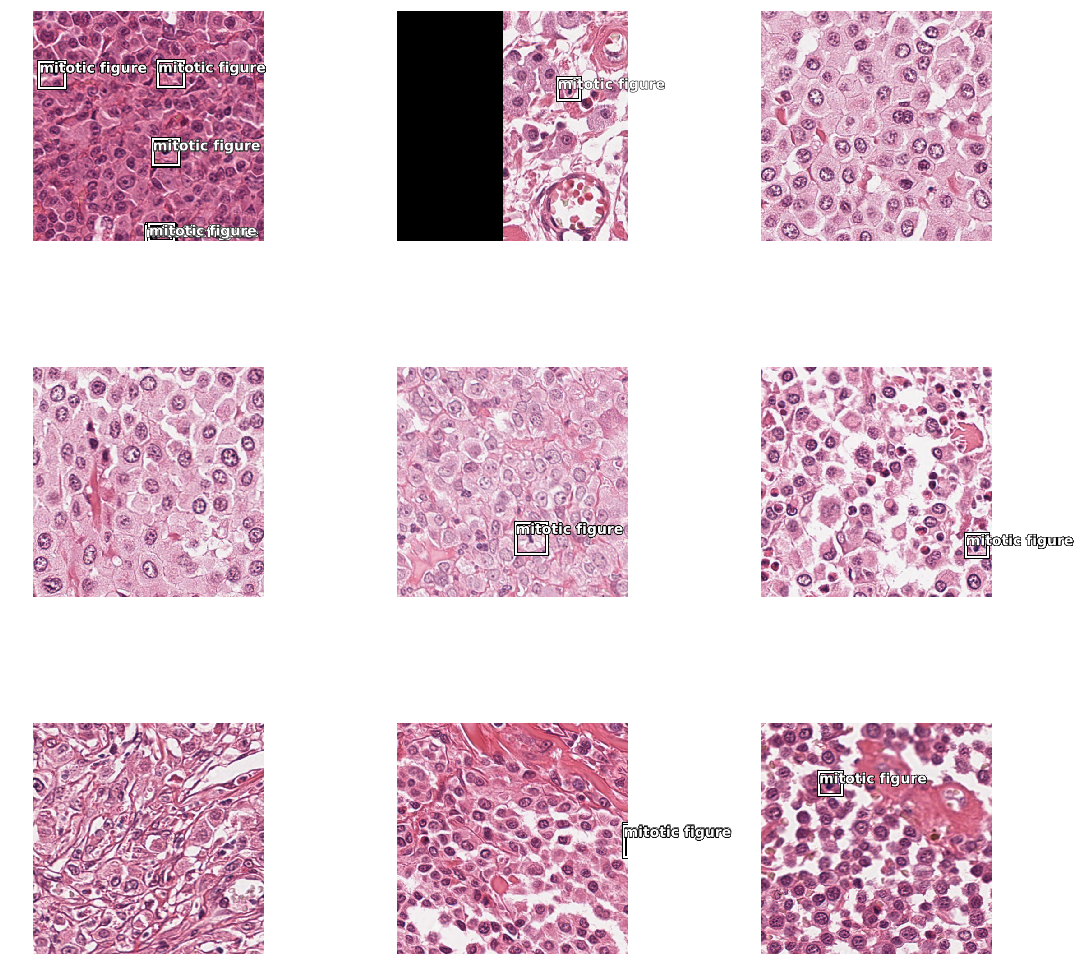

In [15]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [16]:
#anchors = create_anchors(sizes=[(16,16), (32,32)], ratios=[1], scales=[0.3, 0.4,0.5])
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.8, 0.9, 1])
#not_found = show_anchors_on_images(data, anchors)

In [17]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [18]:
voc = PascalVOCMetric(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [19]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-mitotic figure,time
0,0.962831,0.755289,0.060157,0.192816,0.562474,0.060157,08:02


GT: 100%|████████████████████████████████████████████████████████████████████████| 4625/4625 [00:00<00:00, 8517.56it/s]


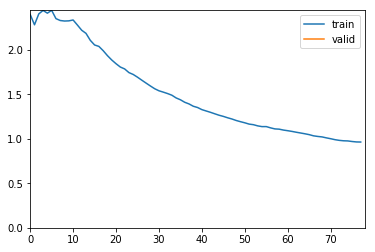

In [20]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-mitotic figure,time
0,0.682096,0.701784,0.066328,0.184689,0.517095,0.066328,07:18
1,0.537431,0.500157,0.089203,0.139112,0.361045,0.089203,07:00
2,0.400055,0.423515,0.099325,0.115959,0.307556,0.099325,07:02
3,0.317354,0.404936,0.101824,0.088625,0.316311,0.101824,06:56
4,0.268907,0.421605,0.110447,0.090765,0.330840,0.110447,06:54
5,0.254849,0.380528,0.106371,0.081530,0.298998,0.106371,06:51
6,0.223189,0.448314,0.106839,0.084263,0.364051,0.106839,06:51
7,0.201988,0.387361,0.109862,0.079092,0.308269,0.109862,06:53
8,0.188080,0.373230,0.110015,0.076103,0.297127,0.110015,06:58
9,0.181852,0.353005,0.109975,0.072475,0.280531,0.109975,06:50


GT: 100%|████████████████████████████████████████████████████████████████████████| 4946/4946 [00:00<00:00, 7644.51it/s]


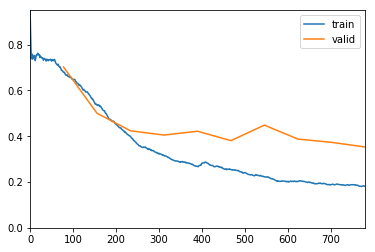

GT: 100%|████████████████████████████████████████████████████████████████████████| 5363/5363 [00:00<00:00, 8162.41it/s]


In [21]:
lr=1e-4
learn.fit_one_cycle(10, lr)